В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [37]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from process_bank_churn import preprocess_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
raw_df = pd.read_csv("https://docs.google.com/spreadsheets/d/11uG3Rk3uaw-RLfTY-dkWST3EdSvhpNQipIu6PylnWBM/gviz/tq?tqx=out:csv&sheet=Sheet1")
data = preprocess_data(raw_df, target_col='Exited', scaler_numeric=True)
X_train, y_train = data['X_train'], data['train_targets']
X_val, y_val = data['X_val'], data['val_targets']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [22]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

train_auc = roc_auc_score(y_train, knn.predict_proba(X_train)[:, 1])
val_auc = roc_auc_score(y_val, knn.predict_proba(X_val)[:, 1])
print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")


Train AUROC: 0.9559
Validation AUROC: 0.8526


Висновок.

Отримана модель з дефолтними параметрами добре навчилась на тренувальних даних оскільки AUROC 95,59% (немає high bias), проте модель гірша на валідаційних даних де AUROC 85,26% тобто є перенавчання моделі (невеликий high variance)

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [30]:
params_knn = {
    'n_neighbors': np.arange(1, 25)
    }
knn_gs = GridSearchCV(knn, params_knn, cv=5, scoring='roc_auc')
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             scoring='roc_auc')

In [31]:
knn_best = knn_gs.best_estimator_
knn_best_score = knn_gs.best_score_
print(f"Best k: {knn_gs.best_params_['n_neighbors']}, Best CV Score: {knn_best_score:.4f}")
knn_best.fit(X_train, y_train)

train_auc_best = roc_auc_score(y_train, knn_best.predict_proba(X_train)[:, 1])
val_auc_best = roc_auc_score(y_val, knn_best.predict_proba(X_val)[:, 1])
print(f"Best Train AUROC: {train_auc_best:.4f}")
print(f"Best Validation AUROC: {val_auc_best:.4f}")

Best k: 19, Best CV Score: 0.8853
Best Train AUROC: 0.9227
Best Validation AUROC: 0.8908


Висновок.

Нова модель з обраним параметром knn = 19 за допомогою GridSearchCV показала досить високий AUROC 92,27% і означає що модель добре натренувалась. AUROC на валідаційних даних (89,08%) нижчий ніж на тренувальних і означає що тут також присутнє перенавчання моделі. Проте порівнюючи з попередньою моделлю де не було обрано найкращого параметра показники покращились. Тобто best train AUROC трохи зменшився (з 0.9559 до 0.9227) — це добре, бо уникнули перенавчання, а best validation AUROC в свою чергу трохи покращився (з 0.8526 до 0.8908) — тобто модель краще узагальнює.

В попередньому завданні AUROC на тренувальних та валідаційних даних був однаковим та становив 91,13%. Порівнюючи за AUROC knn модель та модель дерев прийняття рішень я обрала останню оскільки вона добре узагальнює дані, має високий показник на валідаційних даних та не містить ознак перенавчання на відміну від knn моделі

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [35]:
dtc = DecisionTreeClassifier(random_state=42)
dtc_params = {
    'max_depth': np.arange(1, 21, 2),
    'max_leaf_nodes': np.arange(2, 10, 1)
}
dtc_gs = GridSearchCV(dtc, dtc_params, cv=3, scoring='roc_auc')
dtc_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc')

In [36]:
dtc_best = dtc_gs.best_estimator_
dtc_best_score = dtc_gs.best_score_
print(f"Best max_depth: {dtc_gs.best_params_['max_depth']}, Best max_leaf_nodes: {dtc_gs.best_params_['max_leaf_nodes']}, Best CV Score: {dtc_best_score:.4f}")
dtc_best.fit(X_train, y_train)

train_auc_dtc = roc_auc_score(y_train, dtc_best.predict_proba(X_train)[:, 1])
val_auc_dtc = roc_auc_score(y_val, dtc_best.predict_proba(X_val)[:, 1])
print(f"Best Train AUROC: {train_auc_dtc:.4f}")
print(f"Best Validation AUROC: {val_auc_dtc:.4f}")

Best max_depth: 5, Best max_leaf_nodes: 9, Best CV Score: 0.8990
Best Train AUROC: 0.9001
Best Validation AUROC: 0.8984


Висновок.

- Дерево рішень має кращу якість на валідації (AUROC = 0.8984).
- Дерево рішень має трохи меншу Train AUROC — це добре: менше перенавчання.
- Дерево рішень — краща модель в цьому випадку в порівнянні з knn моделлю
- В порівнянні з результатами пошуку оптимальних параметрів вручну дана модель показує невелике перенавчання при тому що параметри знайдені вручну є оптимальнішими і модель при яких не містить ознак перенавчання

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [39]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [45]:
dtc_rs = RandomizedSearchCV(
    dtc,
    params_dt,
    n_iter=40,
    cv=3,
    scoring='roc_auc',
    random_state=42
)
dtc_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [46]:
dt_random_search_best = dtc_rs.best_estimator_
dt_random_search_best_score = dtc_rs.best_score_
print(f"Best parameters from RandomizedSearchCV: {dtc_rs.best_params_}, Best CV Score: {dt_random_search_best_score:.4f}")
dt_random_search_best.fit(X_train, y_train)

train_auc_dtc_rs = roc_auc_score(y_train, dt_random_search_best.predict_proba(X_train)[:, 1])
val_auc_dtc_rs = roc_auc_score(y_val, dt_random_search_best.predict_proba(X_val)[:, 1])
print(f"Train AUROC with RandomizedSearchCV: {train_auc_dtc_rs:.4f}")
print(f"Validation AUROC with RandomizedSearchCV: {val_auc_dtc_rs:.4f}")

Best parameters from RandomizedSearchCV: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}, Best CV Score: 0.9109
Train AUROC with RandomizedSearchCV: 0.9169
Validation AUROC with RandomizedSearchCV: 0.9166


Висновок.

Модель з RandomizedSearchCV показує найкращу збалансовану якість: тренування і валідація майже однакові (~ 91.7%). Це означає що модель навчене добре, але не перенавчена. RandomizedSearch досліджує значну більшу кількість гіперпараметрів, ніж GridSearch — тому й знайшов кращу комбінацію.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [47]:
from process_bank_churn import preprocess_new_data

test_raw_data = pd.read_csv("https://docs.google.com/spreadsheets/d/1oRLDSQ8Mlc0nq_mTS7ffBFWij7WMGu5lh1-5H5abBWc/gviz/tq?tqx=out:csv&sheet=Test")
test_df = preprocess_new_data(test_raw_data, scaler=data['scaler'], encoder=data['encoder'], input_cols=data['input_cols'])
# Predict on the test set
test_df['Exited'] = dtc_rs.predict(test_df)

# Read sample_submission.csv file
sample_submission = pd.read_csv("https://docs.google.com/spreadsheets/d/1OuQDoTmdSp2jDaBEGLF3pOWXJvj0USSem35Elxxfg4M/gviz/tq?tqx=out:csv&sheet=SampleSubmission")
# Save the predictions to the sample_submission DataFrame by id without indexes
sample_submission['Exited'] = test_df['Exited']
# Save csv file with predictions
sample_submission.to_csv("submission_des_tree_RS_best.csv", index=False)

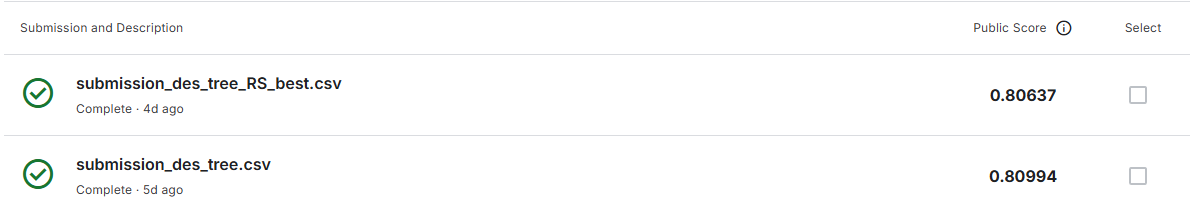